In [1]:
import os
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms

from efficientdet_arch.efficientdet.dataset import CocoDataset, Resizer, Normalizer, Augmenter, collater
from efficientdet_arch.backbone import EfficientDetBackbone
from efficientdet_arch.efficientdet.utils import BBoxTransform, ClipBoxes
from efficientdet_arch.utils.utils import preprocess, postprocess, invert_affine, display
from helper import *  # including config

In [2]:
torch.cuda.is_available()

True

In [3]:
INPUT_DIM = [512, 640, 768, 896, 1024, 1280, 1280, 1536, 1536]

PROJECT_NAME = "goodbadchili"
EFFICIENTNET_COMPOUND_COEF = 0
BATCH_SIZE = 32
EPOCH_NUM = 5
LEARNING_RATE = 1e-4
OPTIMIZER = "AdamW"
WEIGHT_PATH = "weights/d0-chili.pth"
ANCHOR_RATIOS=[(1.0, 0.7), (1.0, 1.0), (1.0, 1.5)]
ANCHOR_SCALES=[2 ** 0, 2 ** (1.0 / 3.0), 2 ** (2.0 / 3.0)]

In [4]:
DATASET_DIR = os.path.join(os.path.abspath(os.getcwd()), "datasets", PROJECT_NAME, "COCO")

DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
train_loader = DataLoader(
    CocoDataset(
        root_dir=DATASET_DIR, set="train",
        transform=transforms.Compose([
            Normalizer(mean=CONFIG["mean"], std=CONFIG["std"]),
            Augmenter(),
            Resizer(INPUT_DIM[EFFICIENTNET_COMPOUND_COEF])
        ])
    ),
    batch_size=BATCH_SIZE, shuffle=True, collate_fn=collater
)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [6]:
model = EfficientDetBackbone(num_classes=2, compound_coef=0, ratios=ANCHOR_RATIOS, scales=ANCHOR_SCALES)
try:
    missing_keys, unexpected_keys = model.load_state_dict(torch.load("original_weights/efficientdet-d0.pth"), strict=False)
except Exception as e:
    print(e, "(Omit)")

Error(s) in loading state_dict for EfficientDetBackbone:
	size mismatch for classifier.header.pointwise_conv.conv.weight: copying a param with shape torch.Size([810, 64, 1, 1]) from checkpoint, the shape in current model is torch.Size([18, 64, 1, 1]).
	size mismatch for classifier.header.pointwise_conv.conv.bias: copying a param with shape torch.Size([810]) from checkpoint, the shape in current model is torch.Size([18]). (Omit)


In [7]:
model.apply(freeze_backbone)
model = ModelWrapper(model, debug=False)
model.to(DEVICE)
model.train()

ModelWrapper(
  (criterion): FocalLoss()
  (model): EfficientDetBackbone(
    (bifpn): Sequential(
      (0): BiFPN(
        (conv6_up): SeparableConvBlock(
          (depthwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          )
          (pointwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
        (conv5_up): SeparableConvBlock(
          (depthwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), groups=64, bias=False)
          )
          (pointwise_conv): Conv2dStaticSamePadding(
            (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          )
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
   

In [8]:
if OPTIMIZER == "AdamW":
    optimizer = torch.optim.AdamW(model.parameters(), LEARNING_RATE)
elif OPTIMIZER == "SGD":
    optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE, momentum=0.9, nesterov=True)
else:
    raise Exception("Wrong Optimizer Option")
    
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, verbose=True)

In [9]:
for epoch in range(EPOCH_NUM):
    epoch_loss = []
    progress_bar = tqdm(train_loader)
    for i, data in enumerate(progress_bar):
        try:
            imgs, annot = data['img'], data['annot']
            imgs, annot = imgs.to(DEVICE), annot.to(DEVICE)

            optimizer.zero_grad()
            cls_loss, reg_loss = model(imgs, annot, obj_list=["good_chili", "bad_chili"])
            cls_loss, reg_loss = cls_loss.mean(), reg_loss.mean()
            loss = cls_loss + reg_loss

            if loss == 0 or not torch.isfinite(loss):
                continue

            loss.backward()
            optimizer.step()
            epoch_loss.append(float(loss))
            progress_bar.set_description(
                f"""Epoch: {epoch}/{EPOCH_NUM} | Iteration: {i+1}/{len(train_loader)} | Cls loss: {cls_loss.item():.5f} | Reg loss: {reg_loss.item():.5f} | Total loss: {loss.item():.5f}"""
            )
        except ValueError as e:
            print(f"[Error] {e}")
    scheduler.step(np.mean(epoch_loss))

torch.save(model.model.state_dict(), WEIGHT_PATH)

Epoch: 0/5 | Iteration: 640/640 | Cls loss: 17.50039 | Reg loss: 1.29323 | Total loss: 18.79362: 100%|███████████████████████████████████████████████████████████████████| 640/640 [09:23<00:00,  1.14it/s]
Epoch: 1/5 | Iteration: 640/640 | Cls loss: 4.24026 | Reg loss: 1.09992 | Total loss: 5.34019: 100%|█████████████████████████████████████████████████████████████████████| 640/640 [09:20<00:00,  1.14it/s]
Epoch: 2/5 | Iteration: 640/640 | Cls loss: 1.74108 | Reg loss: 1.21368 | Total loss: 2.95476: 100%|█████████████████████████████████████████████████████████████████████| 640/640 [09:20<00:00,  1.14it/s]
Epoch: 3/5 | Iteration: 640/640 | Cls loss: 1.08604 | Reg loss: 1.16348 | Total loss: 2.24953: 100%|█████████████████████████████████████████████████████████████████████| 640/640 [09:19<00:00,  1.14it/s]
Epoch: 4/5 | Iteration: 640/640 | Cls loss: 0.76134 | Reg loss: 1.28005 | Total loss: 2.04138: 100%|█████████████████████████████████████████████████████████████████████| 640/640 [09:1

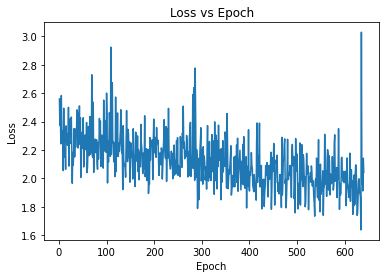

In [10]:
epochs = range(1, len(epoch_loss)+1)

plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, epoch_loss)
plt.show()